In [1]:
# vision transformer for mel-spectrograms

In [4]:
import librosa
from torch import nn
import torch
import torchaudio
from torch.utils.data import Dataset
import os
import soundfile
from torch.utils.data import DataLoader, random_split
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torchaudio.list_audio_backends())
TRAIN_DIR = './data/train/binary_classification/yes_no/'

cuda ['soundfile']


In [24]:
# loading data to dataset:
class MFCCDataset(Dataset):

    def __init__(self, directory):
        self.directory = directory
        self.classes = os.listdir(directory)
        paths = []
        for cl in self.classes:
            tmp = [os.path.join(directory+cl, path) for path in os.listdir(directory + cl)]
            paths+=tmp
        self.paths = paths
    
    
    def __len__(self):
        
        return len(self.paths)
    
    def __getitem__(self, index):
        audio_sample_path = self.paths[index]
        label = self.paths[index].split('/')[-1].split('\\')[0]

        signal, sr = torchaudio.load(audio_sample_path, format = 'wav')
        signal = signal.numpy().ravel()
        mfcc = librosa.feature.mfcc(y = signal, sr = sr, dct_type=3)
        return mfcc, label
        

In [26]:
dataset = MFCCDataset(TRAIN_DIR)
train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
validation_dataset = DataLoader(validation_dataset, batch_size = 64, shuffle=True)

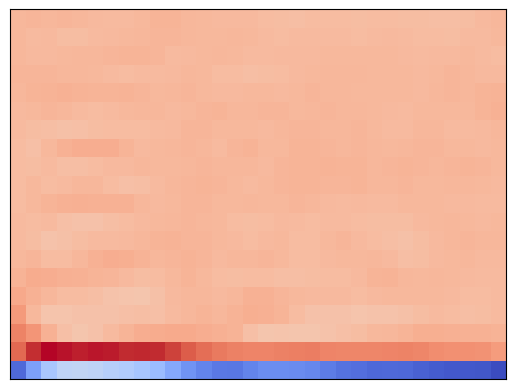

In [25]:
librosa.display.specshow(train_dataset[0][0]) # dct-type = 2